In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
import torch.utils.data as udata
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Generation of 1D piecewise constant signals
class PieceWiseConstantDataset(udata.Dataset):

    def __init__(self, n_data = 1000, n_signal = 40, prob=0.3, fix_datapoints = True,
                  min_val = 0, max_val = 1, min_sep = 20, min_diff=0.4, use_circular_shift=True, circular_shift_get_item= False, seed=0, shift_item = False):
        super(PieceWiseConstantDataset, self).__init__()

        assert(min_sep > 0)
        self.n_data = n_data;
        self.n_signal = n_signal;
        self.prob = prob
        self.fix_datapoints = fix_datapoints;
        self.min_val = min_val;
        self.max_val = max_val;
        self.min_sep = min_sep;
        self.min_diff = min_diff
        assert min_diff < (max_val-min_val)/2

        self.use_circular_shift = use_circular_shift
        self.circular_shift_get_item = circular_shift_get_item
        self.shift_item =shift_item

        np.random.seed(seed)

        if self.fix_datapoints:
            self.data_list = [None] * self.n_data;
            for i in range(self.n_data):
                # self.data_list[i] = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
                self.data_list[i] = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

    def __len__(self):
        return self.n_data

    def circular_shift_shift(self, signal, shift):
        return np.roll(signal, shift)

    def circular_shift(self, signal, shift):
        if shift > int(self.n_signal/2):
          return np.flip(signal).copy()
        else:
          return signal


    def gen_piecewise_constant(self, n, prob, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        min_diff = self.min_diff
        signal = np.zeros(n)
        val = np.random.uniform(min_val, max_val);
        ind = np.random.randint(n)
        for i in range(n):
            signal[ind] = val
            if np.random.rand() < prob:

                new_val = np.random.uniform(min_val, max_val)
                # Ensure the new value differs from the old value by at least min_diff
                while abs(new_val - val) < min_diff:
                    new_val = np.random.uniform(min_val, max_val)
                val = new_val
                # val = np.random.uniform(min_val, max_val);
            ind = np.mod(ind + 1,n)
        return signal

    def gen_piecewise_constant_minsep(self, n, prob, minsep, min_val, max_val):
        # np.random.seed(seed)  # Set the seed for reproducibility
        signal = np.zeros(n)
        ind = 0
        val = np.random.uniform(min_val, max_val);
        while ind < n:
            if ind + minsep > n:
                signal[ind:] = val
                break
            if ind == 0 or np.random.rand() < prob:
                val = np.random.uniform(min_val, max_val);
                sep = np.random.randint(1, minsep+1) if ind == 0 else minsep;
                if ind + sep > n:
                    signal[ind:] = val
                    break
                else:
                    signal[ind:(ind+sep)] = val
                    ind += sep
            else:
                signal[ind] = val
                ind += 1
        if self.use_circular_shift:
          shift = np.random.randint(n)
          # print(signal)
          signal = self.circular_shift(signal, shift)
        return signal

    def __getitem__(self, index):

        if self.fix_datapoints:
            signal = self.data_list[index];
        else:
            # signal = self.gen_piecewise_constant(self.n_signal, self.prob, min_val=self.min_val, max_val=self.max_val);
            signal = self.gen_piecewise_constant_minsep(self.n_signal, self.prob, self.min_sep,
                                                    min_val=self.min_val, max_val=self.max_val);

        if self.circular_shift_get_item:
          shift = np.random.randint(self.n_signal)
          if not self.shift_item:
            signal = self.circular_shift(signal, shift)
          else:
            signal = self.circular_shift_shift(signal, shift)



        return torch.from_numpy(signal).unsqueeze(0).type(torch.FloatTensor)

In [3]:
# Generation of noise
def get_noise(signal, noise_std=0.1, noise_scale=1, max_noise=1,  mode='G'):
    if mode == 'poisson':
        scaled_signal = signal * noise_scale
        noise_sample = torch.tensor(np.random.poisson(scaled_signal.numpy()))
        noise = (noise_sample - scaled_signal) / noise_scale
    else:
        noise = torch.normal(0, noise_std, size=signal.shape)

    noise = torch.clamp(noise, -max_noise, max_noise)
    return noise


In [4]:
# Evaluation of denoising error
def evaluate_error(model, dataset_val, noise_std):
    model.eval()
    error_val = 0;
    total_length = 0;

    criterion = nn.MSELoss(reduction='mean');

    for data in dataset_val:
        out_val = model(data + get_noise(data, noise_std) );
        error_val += criterion(out_val, data).item()
        total_length += 1;

    return error_val/total_length

In [5]:
# Training of the denoising neural network with continuous noise sampling
def train_network(model, train_loader, val_loader, noise_std, max_epoch = 50,
                           milestone = 50, lr=0.001):

    optimizer = optim.Adam(model.parameters(), lr=lr);

    criterion = nn.MSELoss()

    train_loss = np.zeros(max_epoch);
    val_loss = np.zeros(max_epoch);

    for epoch in range(max_epoch):

        if epoch > milestone:
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr/100;
        loss_all = 0
        total_length = 0
        for i, data in enumerate(train_loader):
            optimizer.zero_grad();
            model.train();

            out_train = model(data + get_noise(data, noise_std) );

            loss = criterion(out_train, data);
            loss.backward()
            optimizer.step()
            loss_all += loss.item()

        train_loss[epoch] = evaluate_error(model, train_loader, noise_std)
        val_loss[epoch] =  evaluate_error(model, val_loader, noise_std)

        if epoch % 10 == 0:
            print(epoch, 'train error: ', train_loss[epoch],'validation error: ',val_loss[epoch])

    return train_loss, val_loss

In [6]:
# 1D convolutional neural network with skip connection
class CNN(nn.Module):
	def __init__(self, depth=20, n_channels=16, image_channels=1, use_bnorm=True, kernel_size=3, use_bias=True, non_linear=True):
		super(CNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.use_bnorm = use_bnorm;
		self.depth = depth;
		self.use_bias= use_bias
		self.non_linear = non_linear


		self.first_layer = nn.Conv1d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		if self.use_bnorm:
			self.bn_layer_list = [None] * (self.depth -2 );

		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv1d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias);
			if self.use_bnorm:
				self.bn_layer_list[i] = nn.BatchNorm1d(n_channels, eps=0.0001, momentum = 0.95)

		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		if self.use_bnorm:
			self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv1d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.use_bias)

		self._initialize_weights()

	def forward(self, x):

		out = self.first_layer(x);
		if self.non_linear:
			out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			if self.use_bnorm:
				out = self.bn_layer_list[i](out);
			if self.non_linear:
				out = F.relu(out)

		out = self.last_layer(out) + x;

		return out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv1d):
				init.orthogonal_(m.weight)
				# print('init weight')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm1d):
				init.constant_(m.weight, 1)
				init.constant_(m.bias, 0)

In [7]:
# Generation of training and validation dataset
signal_length = 100
train_dataset = PieceWiseConstantDataset(n_data = 500, prob = 0.3, n_signal = signal_length, fix_datapoints = True, min_sep = 5, use_circular_shift=False, circular_shift_get_item=True);
val_dataset = PieceWiseConstantDataset(n_data = 100, n_signal = signal_length, prob = 0.3, min_sep = 5, use_circular_shift=False);
train_loader = DataLoader(dataset=train_dataset,
                          num_workers=0,
                          batch_size=32, shuffle=True);

val_loader = DataLoader(dataset = val_dataset,
                       num_workers = 0,
                       batch_size = 1,
                       shuffle = False)

In [8]:
# Specification of network architecture
net_nn = CNN(depth=10, n_channels=64, image_channels=1, use_bnorm=False, kernel_size=3)

In [9]:
net_nn

CNN(
  (first_layer): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (hidden_layer_list): ModuleList(
    (0-7): 8 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (last_layer): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [10]:
# Training
noise_scale = noise_std = 0.1
train_loss_cnn, val_loss_cnn = train_network(net_nn, train_loader, val_loader,
                       noise_std=noise_std,
                       max_epoch = 100,
                       milestone = 50,
                      lr = 1e-2)

0 train error:  0.010079363361001015 validation error:  0.009808092000894249
10 train error:  0.0025796335539780557 validation error:  0.002682667603949085
20 train error:  0.0026442025700816885 validation error:  0.0026519490324426443
30 train error:  0.002569387565017678 validation error:  0.0026781637070234865
40 train error:  0.0024031120410654694 validation error:  0.002523969554458745
50 train error:  0.002589016003184952 validation error:  0.002577345804311335
60 train error:  0.002412960064248182 validation error:  0.002334881303831935
70 train error:  0.0023730923421680927 validation error:  0.0023941063118400052
80 train error:  0.0023513599444413558 validation error:  0.002313232647138648
90 train error:  0.002399028220679611 validation error:  0.002362220698851161


In [15]:
def zero_gradients(inputs):
    for inp in inputs:
        if inp.grad is not None:
            inp.grad.data.zero_()

def compute_jacobian_and_bias_1d(inputs, net):
    inputs.requires_grad = True
    assert inputs.requires_grad

    outputs = net(inputs)

    assert(outputs.dim() == 3)
    assert(outputs.shape[0] == 1)
    assert(inputs.shape[1] == 1)

    channels = outputs.shape[1]
    n = inputs.shape[-1]
    total_dim = n*channels

    jacobian = torch.zeros([total_dim, n])
    grad_output = torch.zeros(n)

    if inputs.is_cuda:
        grad_output = grad_output.cuda()
        jacobian = jacobian.cuda()

    for j in range(channels):
        for i in range(n):
            zero_gradients([inputs])
            outputs[0, j, i].backward(retain_graph=True)
            jacobian[j*channels + i, :] = inputs.grad.data.view(-1)

    bias = outputs[0].view(-1) - torch.matmul(jacobian, inputs[0,0])

    return jacobian.cpu().numpy(), bias.data.cpu().numpy()

In [19]:
index = 1
signal = val_dataset[index]
noisy = signal + get_noise(signal, mode='G', noise_std=noise_std, noise_scale=noise_scale)
# Denoise the noisy data using the neural network
noisy.requires_grad = True
denoised = net_nn(noisy.unsqueeze(0))

In [22]:
jacobian, bias = compute_jacobian_and_bias_1d(torch.tensor(noisy.detach().numpy()).unsqueeze(0), net_nn)

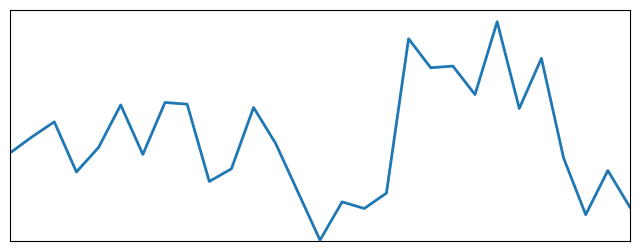

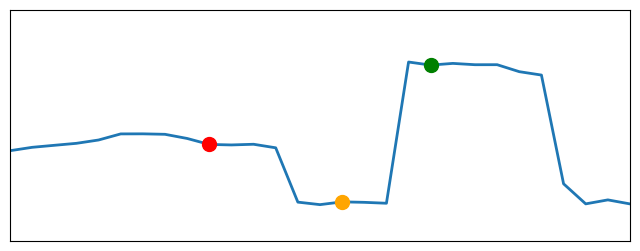

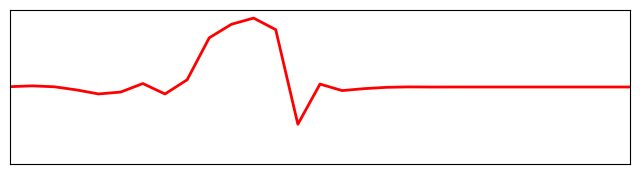

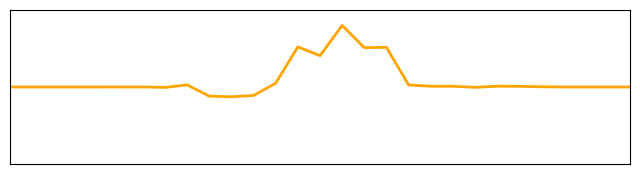

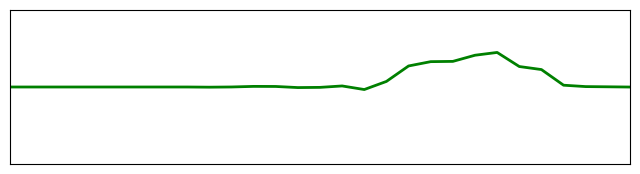

In [23]:
xlim_min = 18
xlim_max = 46
# Global font settings
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 18  # Adjust based on your needs
plt.rcParams['axes.titlesize'] = 20  # Title font size
plt.rcParams['axes.labelsize'] = 18  # Label font size
plt.rcParams['xtick.labelsize'] = 16  # Tick label font size
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['lines.linewidth'] = 2  # Line width


xlim_min = 18
xlim_max = 46


ylim_min = 0.2
ylim_max = 1
figsize = (8, 3)  # Example size, adjust as needed
output_positions = [27, 33, 37]
colors = ['red', 'orange', 'green']  # Colors for the marker points

noisy_data = noisy[0].cpu().data.numpy()
denoised_data = denoised[0,0].cpu().data.numpy()

fig, ax = plt.subplots(figsize=figsize)
ax.plot(noisy_data, label='Noisy')
ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

fig, ax = plt.subplots(figsize=figsize)
ax.plot(denoised_data, label='Denoised')

# Add marker points to the denoised signal
for pos, color in zip(output_positions, colors):
    ax.plot(pos, denoised_data[pos], 'o', color=color, markersize=10)  # Marker point on denoised signal

ax.set_xlim(xlim_min, xlim_max)
ax.set_ylim(ylim_min, ylim_max)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

# Re-enable the spines (borders) of the plot
for spine in ax.spines.values():
    spine.set_visible(True)

plt.show()

figsize = (8, 2)

ylim_min = -0.4
ylim_max = 0.4
# Now plot and save the gradients with corresponding colors
for i, (pos, color) in enumerate(zip(output_positions, colors)):
    fig, ax = plt.subplots(figsize=figsize)
    gradient = jacobian[pos, :]
    ax.plot(gradient, color=color)
    ax.set_xlim(xlim_min, xlim_max)
    ax.set_ylim(ylim_min, ylim_max)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('')
    ax.set_ylabel('')

    # Re-enable the spines (borders) of the plot
    for spine in ax.spines.values():
        spine.set_visible(True)
    plt.show()
